<a href="https://colab.research.google.com/github/wonderalexandre/MorphoTreeAdjust/blob/main/notebooks/morphoTreeAdjust_example_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Library

In [1]:
!pip install morphoTreeAdjust
!pip install PrettyPrintTree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for morphoTreeAdjust: filename=morphoTreeAdjust-0.1.6-cp311-cp311-linux_x86_64.whl size=191155 sha256=41425c13fa0796d47172064d9186730d4308428fc36baab2e4c8854377ea74eb
  Stored in directory: /root/.cache/pip/wheels/43/c4/2e/2e6042d42b8dd17a221868cd089c660cc85545d582cc189160
Successfully built morphoTreeAdjust
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.0 MB/s eta 0:00:00


# 2. Importing library and defining plotting functions

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import morphoTreeAdjust as mta

from PrettyPrint import PrettyPrintTree
from colorama import Fore, Back

printTree = PrettyPrintTree(
    lambda node: node.children,
    lambda node: (str(node.id) + ": " +str(node.level) +": " +str(node.area)), color=Back.BLACK + Fore.WHITE,
    start_message=lambda node: f'Each node is represented by <index>: <gray level>\n'
)

def showLevelSets(img_f):
    print("Upper and lower level sets where in black are foreground pixels and white are background pixels")
    t_values = np.unique(img_f)
    len = np.size(t_values)
    max_value = np.max(img_f)
    fig, axes = plt.subplots(len, 2, figsize=(5, 15))

    # Preenchendo os subplots com imagens limiares
    for i, t in enumerate(t_values):
        # Primeira coluna: img_f >= t
        thr = t_values[i]
        img_threshold_ge = np.where(img_f >= thr, 1, 0)
        axes[i, 0].imshow(img_threshold_ge, cmap='gray_r', vmax=1, vmin=0, interpolation='nearest')
        axes[i, 0].set_title(f'image ≥ {t}')
        axes[i, 0].axis('off')
        axes[i, 0].add_patch(plt.Rectangle((0, 0), img_threshold_ge.shape[1] - 1, img_threshold_ge.shape[0] - 1,
                                   edgecolor='red', linewidth=0.5, fill=False))
        # Segunda coluna: img_f <= t
        thr = t_values[len - i -1]
        img_threshold_le = np.where(img_f <= thr, 1, 0)
        axes[i, 1].imshow(img_threshold_le, cmap='gray_r',vmax=1, vmin=0, interpolation='nearest')
        axes[i, 1].set_title(f'image ≤ {thr}')
        axes[i, 1].axis('off')
        axes[i, 1].add_patch(plt.Rectangle((0, 0), img_threshold_le.shape[1] - 1, img_threshold_le.shape[0] - 1,
                                   edgecolor='blue', linewidth=0.5, fill=False))

    # Ajuste de layout para evitar sobreposição
    plt.tight_layout()
    plt.show()


def computeCentroid(cnps):
    closest_pixel = cnps[len(cnps)//2]
    px, py = closest_pixel // num_cols, closest_pixel % num_cols
    return px, py

def showTree(tree):
    if(tree.isMaxtree):
        print("Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.")
    else:
        print("Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.")
    img_vector = tree.reconstructionImage()
    ids_position = []

    for node in tree.root.postOrderTraversal():
      px, py = computeCentroid(node.cnps)
      ids_position.append( (node.id, px, py) )

    # Plota a imagem
    plt.figure(figsize=(8, 6))
    image = img_vector.reshape(tree.numRows, tree.numCols)
    # Adicionando uma borda ao redor da imagem
    ax = plt.gca()  # Obtém o eixo atual
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                               edgecolor='red', linewidth=0.5, fill=False))

    plt.imshow(image, cmap='gray')

    # Adiciona rótulos nos centróides fictícios
    for i, (id, x, y) in enumerate(ids_position):
        plt.text(y, x, f'•{id}', color='red', fontsize=9)


    plt.axis('off')
    plt.show()
    printTree(tree.root)

def showNode(node):
    image = node.recNode().reshape(num_rows, num_cols)
    ax = plt.gca()  # Obtém o eixo atual
    ax.imshow(image, cmap='gray_r')
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                               edgecolor='red', linewidth=0.5, fill=False))
    ax.set_title(f"{node}")
    ax.axis("off")

def buildMapIds(tree):
    mapIds = np.zeros(num_rows*num_cols)
    for p in range(num_rows*num_cols):
        mapIds[p] = tree.getSC(p).id
    return mapIds


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

def getNodeContour(tree, node):
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)  # Relação de adjacência
    contour = []

    for idP in node.cnps:  # Percorre os pixels do nó
        for idQ in adj.getAdjPixels(idP):  # Verifica seus vizinhos
            sc_p = tree.getSC(idP)
            sc_q = tree.getSC(idQ)

            if sc_p and sc_q and sc_p.id != sc_q.id:  # Verifica se são nós diferentes
                pixel_x = idQ // num_cols
                pixel_y = idQ % num_cols
                contour.append((pixel_y, pixel_x))  # (x=coluna, y=linha)

    return contour



def showNodesOfSubtree(tree, root):
    image = tree.reconstructionImage().reshape(num_rows, num_cols)
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    # Desenha a borda do retângulo em vermelho
    ax.add_patch(patches.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                                   edgecolor='red', linewidth=0.5, fill=False))

    colormap = plt.colormaps['Paired']  # Obtém a paleta de cores (versão compatível)
    ids_position = []
    map_adj = {}

    for node in root.BFSTraversal():
        contours_x = []
        contours_y = []
        color = colormap(node.id % 10)  # Seleciona cor baseada no ID do nó

        # Obtém um ponto de referência do nó para exibir seu ID
        (px, py) = computeCentroid(node.cnps)
        ids_position.append((node.id, px, py, color))

        contour = getNodeContour(tree, node)
        if contour:
            contour_x, contour_y = zip(*contour) if contour else ([], [])
            ax.scatter(contour_x, contour_y, color=color, s=0.5, label=f"Node {node.id}")

        for idP in node.cnps:
            for idQ in adj.getAdjPixels(idP):
                sc_p = tree.getSC(idP)
                sc_q = tree.getSC(idQ)
                if sc_p and sc_q and sc_p.id != sc_q.id:
                    if idQ not in map_adj:
                        nodeQ = sc_q
                        (qx, qy) = computeCentroid(nodeQ.cnps)
                        map_adj[idQ] = (nodeQ.id, qx, qy)




    # Plota os IDs dos nós vizinhos (em vermelho)
    for node_id, x, y in map_adj.values():
        plt.text(y, x, f'{node_id}', color='red', fontsize=9)

    # Plota os IDs dos nós no centro
    for node_id, x, y, color in ids_position:
        plt.text(y, x, f'{node_id}*', color=color, fontsize=9)


    ax.set_title(f"Subárvore com raiz {root}")
    ax.axis("off")  # Remove os eixos
    plt.show()


# 3. Creating the mintree and maxtree of an input image

- Image of the JMIV paper

Upper and lower level sets where in black are foreground pixels and white are background pixels


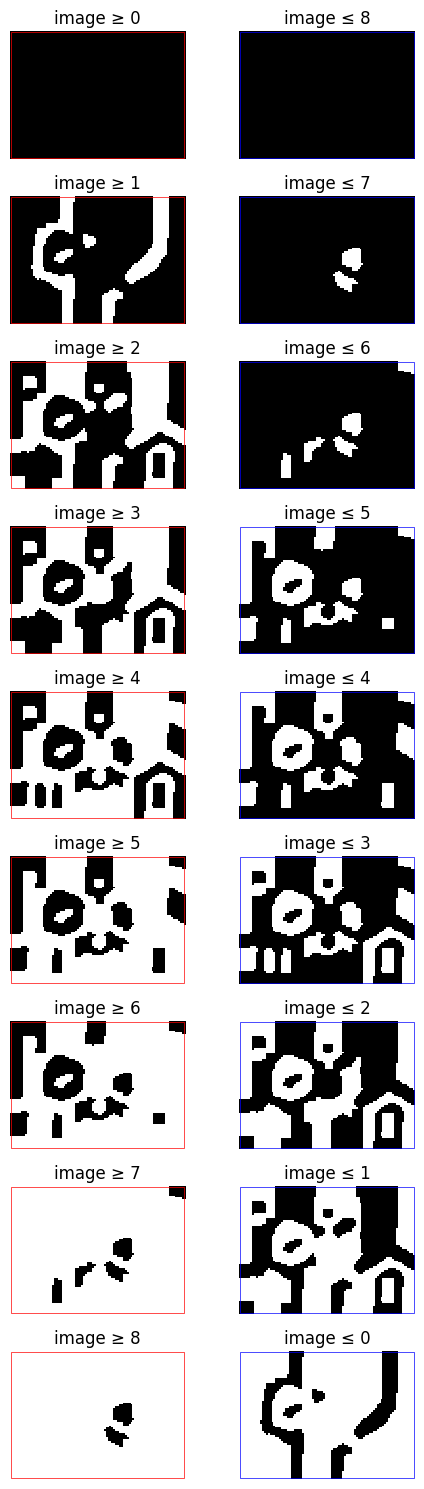




Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


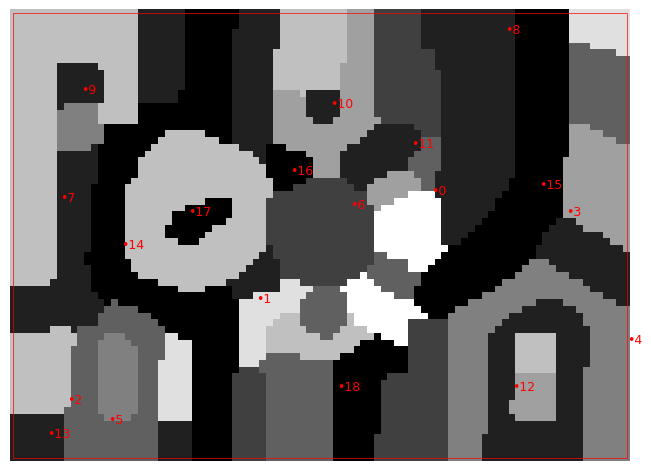

Each node is represented by <index>: <gray level>

                                                                                                 0: 8: 6164 
                                                                                                     |
                                                                                                 1: 7: 5998 
                                                                                                     |
                                                                                                 2: 6: 5818 
                                                                                       ┌─────────────┴──────────────┐
                                                                                   3: 5: 4633                   17: 0: 44 
                                                                      ┌────────────────┴────────────────┐                 
                                                    

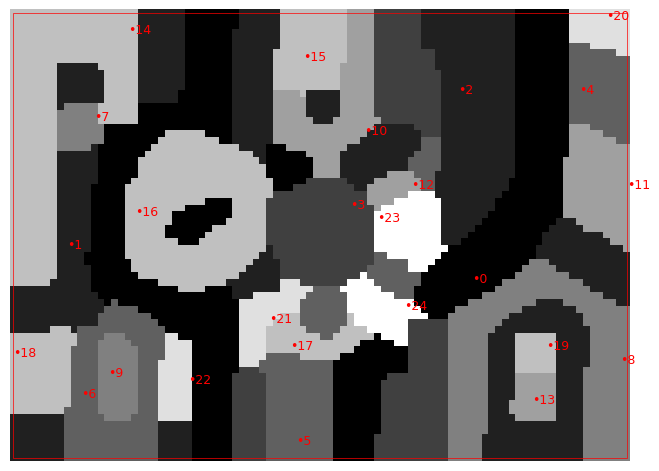

Each node is represented by <index>: <gray level>

                                                                      0: 0: 6164 
                            ┌─────────────────────────────────────────────┴──────────────────────────────────────────────┐
                        1: 1: 1353                                                                                   2: 1: 3638                                 
                ┌───────────┴────────────┐                                               ┌───────────────────────────────┴─────────────┬──────────────────┐     
            6: 3: 464                7: 4: 474                                       3: 2: 2261                                    4: 3: 311          13: 5: 80 
    ┌───────────┼────────────┐           |                     ┌─────────────────────────┴─┬───────────┬────────────┐            ┌─────┴──────┐           |     
 9: 4: 72   18: 6: 112   22: 7: 59   14: 6: 431            5: 3: 595                   8: 4: 378   1

In [14]:
img_jmiv = np.array([
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,6,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,1,1,1,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,1,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,1,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,0,0,0,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,0,0,0,0,0,0,5,5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,5,5,5,5,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,5,5,5,5,5,5,5,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,2,2,2,2,2,2,2,2,2,1,1,5,5,5,5,5,5,5,5,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,5,5,5,5,5,8,8,8,8,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,5,5,5,8,8,8,8,8,8,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,0,0,0,6,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,5],
    [6,6,6,6,6,6,6,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,8,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,1,7,7,7,2,2,2,2,2,2,2,8,8,8,8,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,6,0,0,0,0,1,1,1,1,1,1,1,7,7,7,7,7,3,3,3,3,8,8,8,8,8,8,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,7,7,7,7,7,7,7,7,3,3,3,3,3,3,8,8,8,8,8,8,8,3,3,3,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7,3,3,3,3,3,3,3,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,1,1,1,1,4,4,4,4,4,4,4,4,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7,3,3,3,3,3,3,3,8,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,6,6,6,3,3,3,3,3,3,3,6,8,8,8,8,8,8,8,8,8,8,8,0,0,0,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,6,6,6,6,3,3,3,3,3,3,3,6,8,8,8,8,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,6,6,6,1,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,3,3,3,3,3,6,6,6,6,8,8,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,3,3,3,3,3,3,7,7,0,0,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,3,3,6,6,6,6,6,6,0,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,6,3,3,3,4,4,4,4,4,3,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,8,8,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,3,3,3,3,3,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,0,7,7,7,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,0,2,2,2,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,5,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,3,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,5,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,4,4,4,4,3,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
])


num_rows, num_cols = img_jmiv.shape
img_jmiv_vector = img_jmiv.ravel()

maxtree = mta.ComponentTree(img_jmiv_vector, num_rows, num_cols, True, 1.5)
mintree = mta.ComponentTree(img_jmiv_vector, num_rows, num_cols, False, 1.5)

showLevelSets(img_jmiv)
print("\n\n")
showTree(mintree)
print("\n\n")
showTree(maxtree)


# 4. Pruning a leaf of the max-tree and adjusting the min-tree

### 4.1 Selecting the leaf

List of leaves of the min-tree:
	 [NodeCT(id=17, level=0), NodeCT(id=10, level=1), NodeCT(id=12, level=1), NodeCT(id=9, level=1), NodeCT(id=13, level=1), NodeCT(id=18, level=0), NodeCT(id=11, level=1), NodeCT(id=15, level=0), NodeCT(id=16, level=0), NodeCT(id=14, level=0)] 



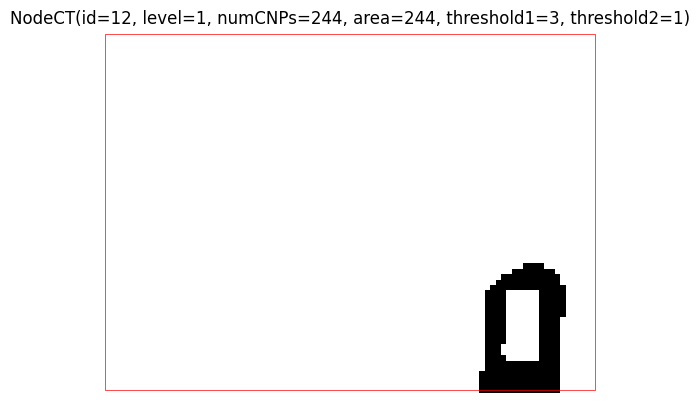

In [15]:
leaves_mintree = mintree.leaves()
print("List of leaves of the min-tree:\n\t", leaves_mintree, "\n")

L = leaves_mintree[2]
showNode(L)

In [16]:
adjust = mta.ComponentTreeAdjustment(mintree, maxtree)

flatZone = L.cnps
oldGrayLevel = L.level
newGrayLevel = L.parent.level
type_treeBeUpdated = True #False=mintree and True=maxtree

(mapF, F_λb) = adjust.buildCollections(maxtree, flatZone, newGrayLevel, type_treeBeUpdated)

print("f(p) = a = ", oldGrayLevel)
print("g(p) = b = ", newGrayLevel)
print("F_λ:", mapF)
print("F_λ>b:", F_λb)

f(p) = a =  1
g(p) = b =  4
F_λ: {1: [NodeCT(id=2, level=1)], 2: [NodeCT(id=3, level=2)], 4: [NodeCT(id=8, level=4)]}
F_λ>b: {NodeCT(id=13, level=5)}


The reconstruction images are equals? True
Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


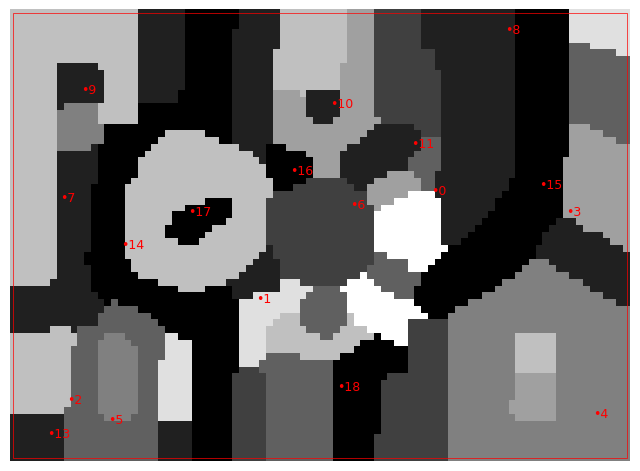

Each node is represented by <index>: <gray level>

                                                                                      0: 8: 6164 
                                                                                          |
                                                                                      1: 7: 5998 
                                                                                          |
                                                                                      2: 6: 5818 
                                                                             ┌────────────┴────────────┐
                                                                         3: 5: 4633                17: 0: 44 
                                                                ┌────────────┴─────────────┐                 
                                                            4: 4: 4218                 10: 1: 23             
                                    

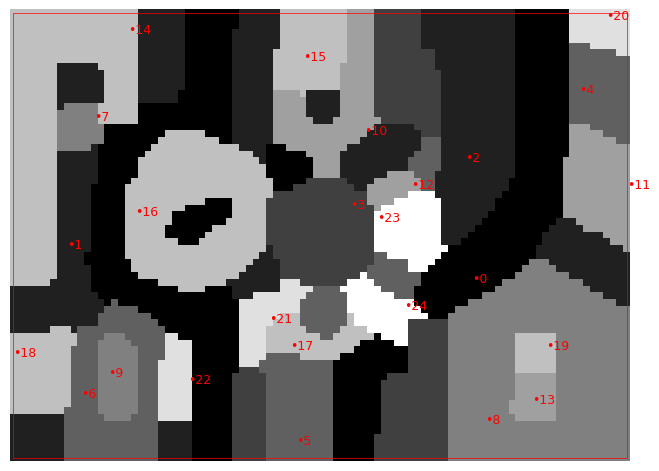

Each node is represented by <index>: <gray level>

                                                     0: 0: 6164 
                            ┌────────────────────────────┴─────────────────────────────┐
                        1: 1: 1353                                                 2: 1: 3638                                                       
                ┌───────────┴────────────┐                  ┌──────────────────────────┴───────────────────────────┐                                
            6: 3: 464                7: 4: 474          4: 3: 311                                              3: 2: 2585                           
    ┌───────────┼────────────┐           |            ┌─────┴──────┐                    ┌──────────────────────────┴┬────────────┬────────────┐     
 9: 4: 72   18: 6: 112   22: 7: 59   14: 6: 431   11: 5: 146   20: 7: 53            5: 3: 595                   10: 5: 295   16: 6: 373   8: 4: 702 
                                                  

In [17]:
adjust = mta.ComponentTreeAdjustment(mintree, maxtree)

adjust.updateTree(maxtree, L)

#after, pruning the maxtree
mintree.prunning(L)
del L

#reconstructed images of both trees
img_g_vector_maxtree = maxtree.reconstructionImage()
img_g_vector_mintree = mintree.reconstructionImage()

print("The reconstruction images are equals?", (img_g_vector_maxtree == img_g_vector_mintree).all() )
showTree(mintree)
print("\n\n")
showTree(maxtree)